In [1]:
import os
import random
from os import listdir
from os.path import isfile, join

import numpy as np
import seaborn as sns
import sklearn.metrics
from matplotlib import pyplot as plt
from skimage import io
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment as linear_assignment

import cv2

from keras import backend as K
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.engine.topology import InputSpec, Layer
from keras.initializers import VarianceScaling
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Input, Reshape
from keras.models import Model
from keras.utils import plot_model
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm
from skimage.transform import rescale, resize
import sys
sys.path.append('../src')
import metrics

Using TensorFlow backend.


In [4]:
exp = 'asd'

## Read images and create datasets

In [5]:
print(os.getcwd())

# creo lista di nomi
directories = ['../data/processed/train/',
               '../data/processed/val/',
               '../data/processed/test/']

train_file_names = [f for f in listdir(
    directories[0]) if isfile(join(directories[0], f))]
val_file_names = [f for f in listdir(
    directories[1]) if isfile(join(directories[1], f))]
test_file_names = [f for f in listdir(
    directories[2]) if isfile(join(directories[2], f))]

_file_names = [train_file_names, val_file_names, test_file_names]

/home/phil/unimib/tesi/notebooks


In [6]:
# numero immagini per categoria
scans = ['CT', 'MRI', 'PET']
numbers = []
minimi = []

for directory in directories:
    for scan in scans:
        a = len([f for f in listdir(directory) if f[:2] == scan[:2]])
        print('Numbero di immagini', scan, 'in', directory, ':', a)
        numbers.append(a)
    minimi.append(min(numbers))

# print(minimi)

Numbero di immagini CT in ../data/processed/train/ : 1585
Numbero di immagini MRI in ../data/processed/train/ : 2879
Numbero di immagini PET in ../data/processed/train/ : 1908
Numbero di immagini CT in ../data/processed/val/ : 378
Numbero di immagini MRI in ../data/processed/val/ : 680
Numbero di immagini PET in ../data/processed/val/ : 428
Numbero di immagini CT in ../data/processed/test/ : 162
Numbero di immagini MRI in ../data/processed/test/ : 292
Numbero di immagini PET in ../data/processed/test/ : 184


In [7]:
# creo la lista di file bilanciata: n.b  la percentuale viene mantenuta
train_final_file_names = []
val_final_file_names = []
test_final_file_names = []
_final_file_names = [train_final_file_names,
                     val_final_file_names, test_final_file_names]

l = []
for directory, minimo, name in zip(directories, minimi, _final_file_names):
    for scan in scans:
        l = [f for f in listdir(directory) if f[:2] == scan[:2]]
        l = l[:minimo]
        name.extend(l)  # estendo la lista (don't append)

# How I cicled ^^^

#    minimo |
#    name   |
#    train  | val | test
#
# CT    ... | ... | ...
# MRI   ... | ... | ...
# PET   ... | ... | ...

for l in _final_file_names:
    random.shuffle(l)

In [8]:
print("DATASET")
print("Training", len(train_final_file_names), ", Validation:", len(
    val_final_file_names), ", Test:", len(test_final_file_names))

DATASET
Training 4755 , Validation: 1134 , Test: 486


## Inspect images

In [9]:
# (188, 224, 3)

(188, 224, 3)
(192, 192, 3)


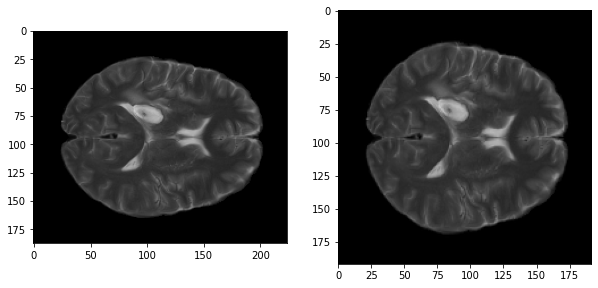

In [10]:
img = cv2.imread(directories[0]+train_final_file_names[random.randint(0, 100)])
h, w, c = img.shape
print(img.shape)
resized = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LANCZOS4)
print(resized.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(resized)

# use full images

In [11]:
def read_images(path):
    labels = []
    images = []
    for i in tqdm(path):
        if 'CT' in i:
            labels.append(0)
        if 'MR' in i:
            labels.append(1)
        if 'PET' in i:
            labels.append(2)
        img = io.imread(i)
        img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LANCZOS4)
        images.append(img)
    y = np.concatenate((labels,))
    x = np.dstack(images)
    x = np.rollaxis(x, -1)
    x = x.reshape(x.shape + (1,))
    x = x/255.
    return x, y

In [12]:
train_paths = []
val_paths = []
test_paths = []
_paths = [train_paths, val_paths, test_paths]

for path, name, directory in zip(_paths, _final_file_names, directories):
    for f in name:
        path.append(directory+f)

x_train, y_train = read_images(train_paths)
x_val, y_val = read_images(val_paths)
x_test, y_test = read_images(test_paths)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

100%|██████████| 486/486 [00:00<00:00, 559.27it/s]


(4755, 192, 192, 1)
(1134, 192, 192, 1)
(486, 192, 192, 1)


# Convolutional Autoencoder

## CAE Conv2DTranspose (paper)

In [37]:
def CAE_Conv2DTranspose(input_shape=(192, 192, 1), filters=[16, 32, 64, 128, 300]):

    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu',name='conv1', input_shape=input_shape)(input_img)
    x = Conv2D(filters[1], 3, strides=2, padding='same',activation='relu', name='conv2')(x)
    #x = Conv2D(filters[2], 3, strides=2, padding='same',activation='relu', name='conv3')(x)
    x = Flatten(name='flatten_1')(x)
    
    encoded = Dense(units=filters[-1], name='embedding')(x)
    
    y = Dense(units=3, name='input_clustering')(encoded)
    
    # Decoder36864
    x = Dense(units=73728, activation='relu')(encoded)

    x = Reshape((48, 48, filters[1]))(x)
    #x = Conv2DTranspose(filters[1], 3, strides=2, padding='same', activation='relu', name='deconv3')(x)
    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)
    decoded = Conv2DTranspose(1, 3, strides=2, padding='same', name='deconv1')(x)

    return Model(inputs=input_img, outputs=decoded, name='CAE_Conv2DTranspose'), Model(inputs=input_img, outputs=[encoded, y], name='CE')

In [38]:
autoencoder, encoder = CAE_Conv2DTranspose()
encoder.summary()
autoencoder.summary()

Model: "CE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 192, 192, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 96, 16)        416       
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 32)        4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
embedding (Dense)            (None, 300)               22118700  
_________________________________________________________________
input_clustering (Dense)     (None, 3)                 903       
Total params: 22,124,659
Trainable params: 22,124,659
Non-trainable params: 0
____________________________________________________

# Pretrain

In [15]:
init = VarianceScaling(
    scale=1./3.,
    mode='fan_in',
    distribution='uniform'
)

pretrain_epochs = 1000
batch_size = 128

autoencoder.compile(optimizer='adam', loss='mse')

my_callbacks = [
    EarlyStopping(patience=10, monitor='val_loss'),
    TensorBoard(log_dir='./logs/'+exp),
    ModelCheckpoint(
        filepath='./models/'+exp, 
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss'
    )
]

In [16]:
autoencoder.fit(
    x_train,
    x_train,
    batch_size=batch_size,
    epochs=pretrain_epochs,
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=my_callbacks,
    verbose=1
)

Train on 4860 samples, validate on 1134 samples
Epoch 1/1000
4860/4860 [==============================] - 60s 12ms/step - loss: 0.0114 - val_loss: 0.0042
Epoch 2/1000
4860/4860 [==============================] - 60s 12ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 3/1000
4860/4860 [==============================] - 60s 12ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 4/1000
4860/4860 [==============================] - 60s 12ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 5/1000
4860/4860 [==============================] - 60s 12ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 6/1000
4860/4860 [==============================] - 60s 12ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 7/1000
4860/4860 [==============================] - 61s 13ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/1000
4860/4860 [==============================] - 66s 14ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 9/1000
4860/4860 [==============================] - 77s 16ms/step - loss: 0.0019 - val_loss: 0.001

## Plot

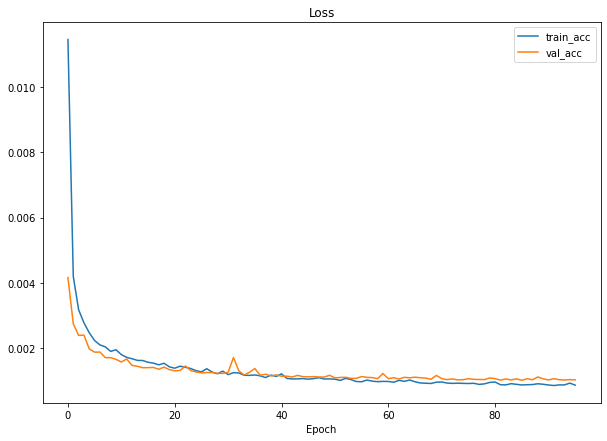

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize=(10,7))
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend([ 'train_acc', 'val_acc'])
plt.show()

plt.savefig('./figures/'+exp)

# Show prediction after pretraining CAE

In [19]:
autoencoder.load_weights('../models/test/cae/cae_weights')

In [24]:
directories = ['../data/processed/train/',
               '../data/processed/val/',
               '../data/processed/test/']
s = ['CT', 'MRI', 'PET']

model = autoencoder

## Pred on test

In [25]:
def get_list_per_type(directory, scan):
    names = [f for f in listdir(directory) if f[:2] == scan[:2]]
    return names

def get_image(names, directory, n):
    image = cv2.imread(directory+names[n])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def pred(model, directory, scan):
    img = get_image(get_list_per_type(directory, scan), directory, n)
    img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LANCZOS4)
    pred_img = model.predict(img.reshape((1,) + img.shape + (1,)))
    pred_img = pred_img.reshape((192, 192))
    plt.figure(figsize=(14,7))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)

In [34]:
n = random.randint(0,10)

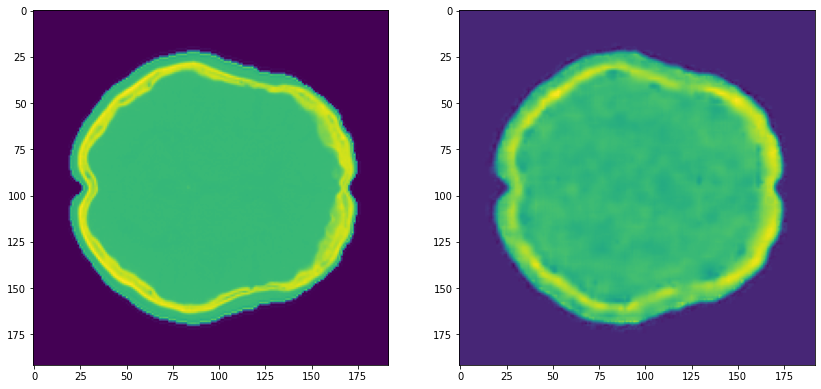

In [35]:
pred(autoencoder, directories[2], 'CT')
#plt.savefig('./figures/'+exp+'/pred_AE_CT')

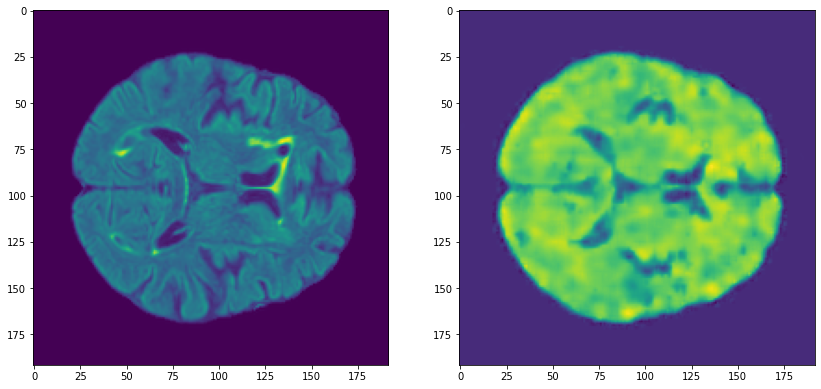

In [36]:
pred(autoencoder, directories[2], 'MRI')
#plt.savefig('./figures/'+exp+'/pred_AE_MRI')

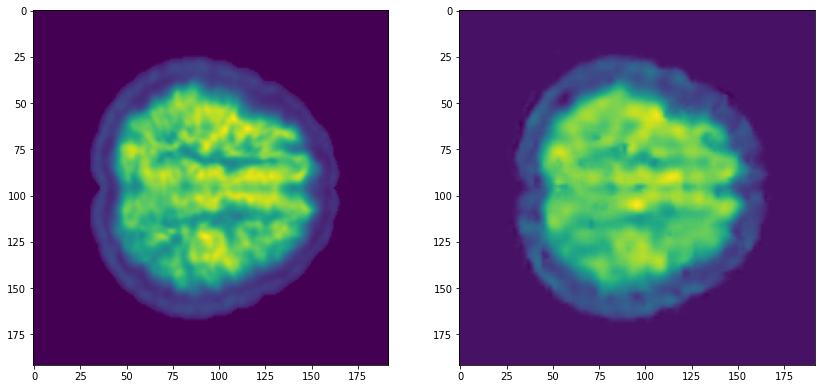

In [37]:
pred(autoencoder, directories[2], 'PET')
#plt.savefig('./figures/'+exp+'/pred_AE_MRI')

# DCEC Model

In [38]:
autoencoder.load_weights('../models/test/cae/cae_weights')

### Clustering Layer

In [39]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=3))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(
            self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs,
                                                       axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        # Make sure each sample's 10 values add up to 1.
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [40]:
n_clusters = 3
clustering_layer = ClusteringLayer(
    n_clusters, name='clustering')(encoder.output[1])
model = Model(inputs=encoder.input, outputs=[
              clustering_layer, autoencoder.output])

In [41]:
#plot_model(model, to_file='model.png', show_shapes=True)

## Inizialize cluster centers using k-means

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

In [42]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)

y_pred = kmeans.fit_predict(encoder.predict(x_train)[1])
y_pred_last = y_pred.copy()

centers = kmeans.cluster_centers_
model.get_layer(name='clustering').set_weights([centers])

In [43]:
print('Metrics before training.')
print('acc =', metrics.acc(y_train, y_pred), 
      'nmi =', metrics.nmi(y_train, y_pred), 
      'ari =', metrics.ari(y_train, y_pred)
     )

Metrics before training.
acc = 0.5476340694006309 nmi = 0.15859712371872073 ari = 0.1495525699770837


### plot train cluster -> todo make 2d graph

In [44]:
# fig = plt.figure(figsize=(10, 10))
# ax = axes3d.Axes3D(fig)

# features = encoder.predict(x_train)[1]
# print(features.shape)

# ax.scatter(features[:, 0], features[:, 1],
#            features[:, 2], c=y_pred, s=20, cmap='brg')
# ax.scatter(centers[:, 0], centers[:, 1],
#            centers[:, 2], c='black', s=200, alpha=1)

### plot test cluster -> todo make 2d graph

In [45]:
# y_pred = kmeans.fit_predict(encoder.predict(x_test)[1])

# fig = plt.figure(figsize=(10, 10))
# ax = axes3d.Axes3D(fig)

# features = encoder.predict(x_test)[1]
# print(features.shape)

# ax.scatter(features[:, 0], features[:, 1],
#            features[:, 2], c=y_pred, s=20, cmap='brg')
# ax.scatter(centers[:, 0], centers[:, 1],
#            centers[:, 2], c='black', s=200, alpha=1)

# Training DCEC

In [33]:
# Student's distribution (see paper)
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [52]:
# hyperparams
batch_size = 16
maxiter = 10000
update_interval = 5000
save_interval = 1000
tol = 0.01  # tolerance as threshold to early stopping

# init
index = 0
val_index = 0
train_loss = []
val_loss = []

# plots
history_train_losses = [[], [], []]
history_val_losses = [[], [], []]
history_train_acc = []
history_val_acc = []
train_iterazioni = []
val_iterazioni = []

## Compile

In [53]:
# compile model
gamma = 0.1
optimizer = 'adam'

model.compile(loss=['kld', 'mse'], loss_weights=[
              gamma, 1], optimizer=optimizer)

## Train and val

In [55]:
#if not os.path.join(models, exp, 'dcec_model_1000.h5'):
# train and val
for ite in tqdm(range(int(maxiter))):
    if ite % update_interval == 0:
        q, _ = model.predict(x_train, verbose=0)
        p = target_distribution(q)
        val_q, _ = model.predict(x_val, verbose=0)
        val_p = target_distribution(val_q)

        # evaluate the clustering performance
        y_train_pred = q.argmax(1)
        if y_train is not None:
            train_acc = np.round(acc(y_train, y_train_pred), 5)
            train_nmi = np.round(nmi(y_train, y_train_pred), 5)
            train_ari = np.round(ari(y_train, y_train_pred), 5)
            train_loss = np.round(train_loss, 5)
            print(
                'Iter', ite, ': Acc tr', train_acc, ', nmi tr', train_nmi,
                ', ari tr', train_ari, '; loss tr=', train_loss
            )

        y_val_pred = val_q.argmax(1)
        if y_val is not None:
            val_acc = np.round(acc(y_val, y_val_pred), 5)
            val_nmi = np.round(nmi(y_val, y_val_pred), 5)
            val_ari = np.round(ari(y_val, y_val_pred), 5)
            val_loss = np.round(val_loss, 5)
            print(
                'Iter', ite, ': Acc val', val_acc, ', nmi val', val_nmi,
                ', ari val', val_ari, ', loss val=', val_loss)

        # check stop criterion on train -> TODO on validation?
        delta_label = np.sum(y_train_pred != y_pred_last).astype(
            np.float32) / y_train_pred.shape[0]
        y_pred_last = np.copy(y_train_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break

    # train on batch
    if (index + 1) * batch_size > x_train.shape[0]:
        train_loss = model.train_on_batch(
            x=x_train[index * batch_size::],
            y=[
                p[index * batch_size::],
                x_train[index * batch_size::]
            ]
        )
        index = 0
    else:
        train_loss = model.train_on_batch(
            x=x_train[
                index * batch_size:(index + 1) * batch_size
                ],
            y=[
                p[index * batch_size:(index + 1) * batch_size], 
                x_train[index * batch_size:(index + 1) * batch_size]
            ]
        )
        index += 1

    # validation on batch
    x_val_batch = np.array(random.sample(list(x_val), batch_size))
    val_p_batch = np.array(random.sample(list(val_p), batch_size))
    val_loss = model.test_on_batch(
        x=x_val_batch,
        y=[val_p_batch, x_val_batch]
    )

    history_train_losses[0].append(train_loss[0])
    history_train_losses[1].append(train_loss[1])
    history_train_losses[2].append(train_loss[2])
    history_train_acc.append(train_acc)
    history_val_losses[0].append(val_loss[0])
    history_val_losses[1].append(val_loss[1])
    history_val_losses[2].append(val_loss[2])
    history_val_acc.append(val_acc)

    train_iterazioni.append(ite)

    # TODO Convert to save the best looking at val_loss? -> overfitting now
    if ite % save_interval == 0:
    #    # save DCEC model checkpoints
    #    print('saving model to:', os.path.join(
    #       models, exp, 'dcec_model_' + str(ite) + '.h5'))
        model.save_weights('dcec_model_' + str(ite) + '.h5')
    ite += 1


  0%|          | 0/10000 [00:02<?, ?it/s]


KeyboardInterrupt: 

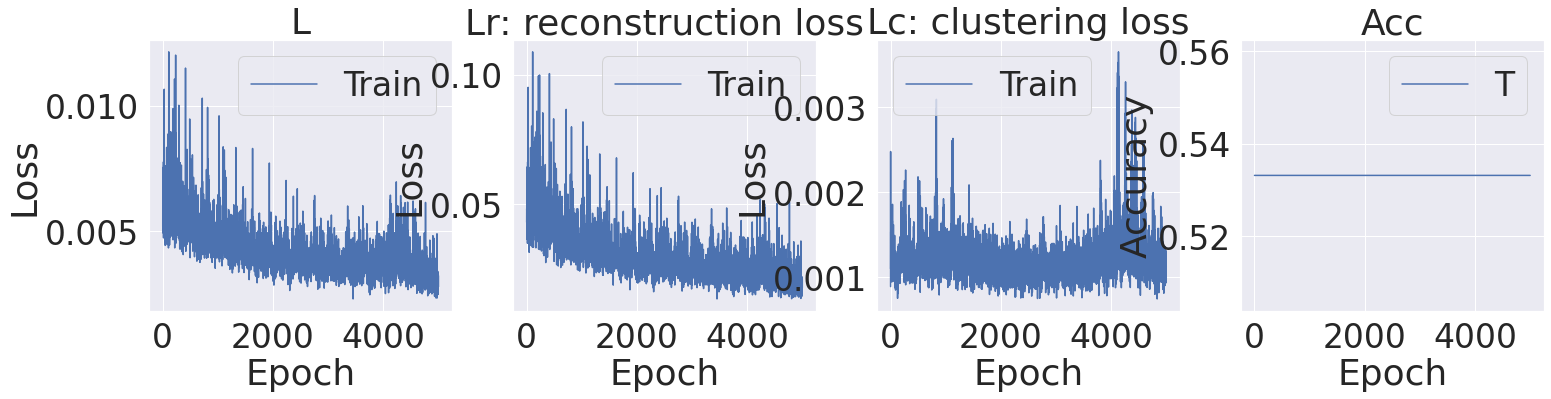

In [60]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 4, 1)
x1 = train_iterazioni
y1 = history_train_losses[0]
plt.plot(x1, y1)
plt.title('L')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 4, 2)
x1 = train_iterazioni
y1 = history_train_losses[1]
plt.plot(x1, y1)
plt.title('Lr: reconstruction loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 4, 3)
x1 = train_iterazioni
y1 = history_train_losses[2]
plt.plot(x1, y1)
plt.title('Lc: clustering loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 4, 4)
x1 = train_iterazioni
y1 = history_train_acc
plt.plot(x1, y1)
plt.title('Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train')

plt.show()

# Validation

In [61]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        val_q, _ = model.predict(x_val, verbose=0)
        # update the auxiliary target distribution p
        val_p = target_distribution(val_q)

        # evaluate the clustering performance
        y_val_pred = val_q.argmax(1)
        if y_val is not None:
            val_acc = np.round(metrics.acc(y_val, y_val_pred), 5)
            val_nmi = np.round(metrics.nmi(y_val, y_val_pred), 5)
            val_ari = np.round(metrics.ari(y_val, y_val_pred), 5)
            val_loss = np.round(val_loss, 5)
            print('Iter', ite, ': Acc val', val_acc, ', nmi val',
                  val_nmi, ', ari val', val_ari, '; loss val=', val_loss)

        # check stop criterion
        delta_label = np.sum(y_train_pred != y_pred_last).astype(
            np.float32) / y_train_pred.shape[0]
        y_pred_last = np.copy(y_train_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break

    # train on batch
    if (val_index + 1) * batch_size > x_val.shape[0]:
        val_loss = model.test_on_batch(
            x=x_val[val_index * batch_size::],                   
            y=[val_p[val_index * batch_size::], x_val[val_index * batch_size::]]
        )
        val_index = 0
    else:
        val_loss = model.test_on_batch(
            x=x_val[val_index * batch_size:(val_index + 1) * batch_size],
            y=[
                val_p[val_index * batch_size:(val_index + 1) * batch_size], 
                x_val[val_index * batch_size:(val_index + 1) * batch_size]
            ]
        )
        val_index += 1 
    
    history_val_losses[0].append(val_loss[0])
    history_val_losses[1].append(val_loss[1])
    history_val_losses[2].append(val_loss[2])
    history_val_acc.append(val_acc)

    val_iterazioni.append(ite)

    ite += 1

Iter 0 : Acc val 0.53704 , nmi val 0.19108 , ari val 0.20058 ; loss val= []
Iter 5000 : Acc val 0.53704 , nmi val 0.19108 , ari val 0.20058 ; loss val= [0.00593 0.04505 0.00142]
delta_label  0.0 < tol  0.01
Reached tolerance threshold. Stopping training.


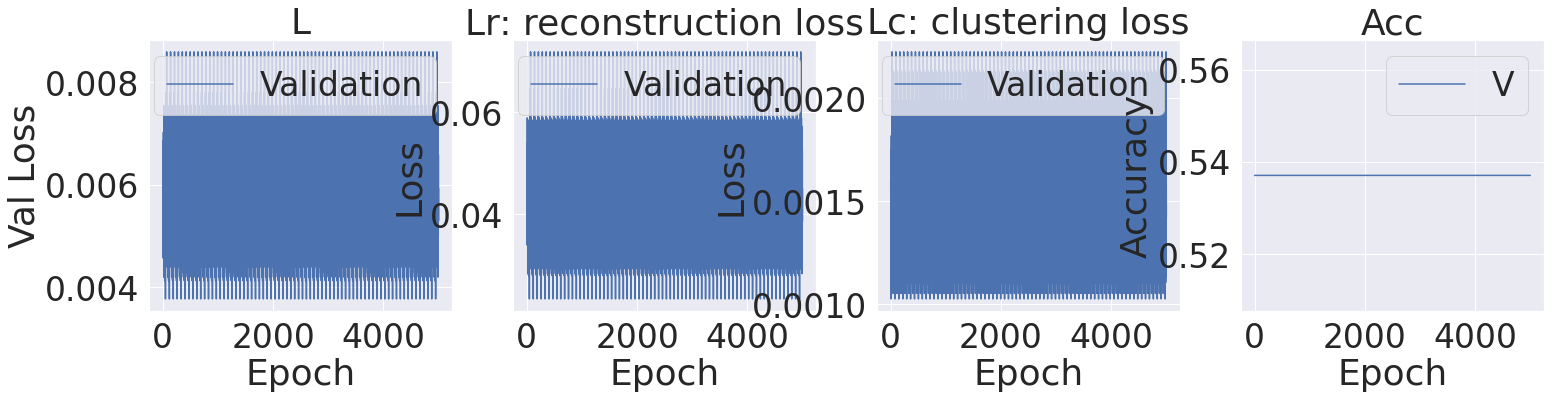

In [62]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 4, 1)
x1 = val_iterazioni
y1 = history_val_losses[0]
plt.plot(x1, y1)
plt.title('L')
plt.ylabel('Val Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'])

plt.subplot(1, 4, 2)
x1 = val_iterazioni
y1 = history_val_losses[1]
plt.plot(x1, y1)
plt.title('Lr: reconstruction loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'])

plt.subplot(1, 4, 3)
x1 = val_iterazioni
y1 = history_val_losses[2]
plt.plot(x1, y1)
plt.title('Lc: clustering loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'])

plt.subplot(1, 4, 4)
x1 = val_iterazioni
y1 = history_val_acc
plt.plot(x1, y1)
plt.title('Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Validation')

plt.show()

## Prediction after training

In [63]:
model.load_weights('./models' + '/dcec_model_final.h5')

In [64]:
pred_encoder = model.predict(x_test)[0]

In [65]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
y_pred = kmeans.fit_predict(pred_encoder)
centers = kmeans.cluster_centers_

print('Metrics after training.')
print('acc =', metrics.acc(y_test, y_pred), 
      'nmi =', metrics.nmi(y_test, y_pred), 
      'ari =', metrics.ari(y_test, y_pred))

Metrics after training.
acc = 0.5267489711934157 nmi = 0.17648607086277016 ari = 0.18710204495094945


(486, 3)


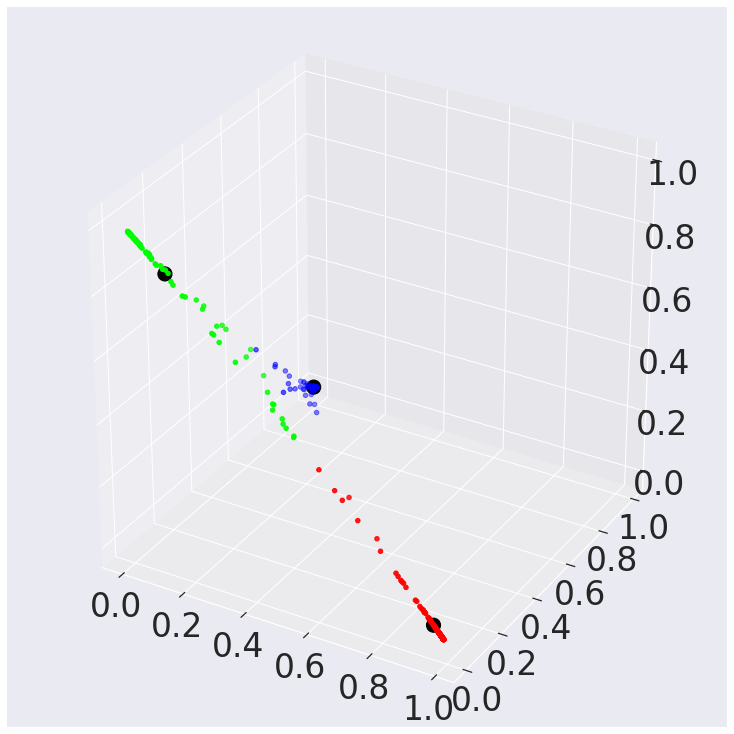

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)

features = pred_encoder
print(features.shape)

ax.scatter(features[:, 0], features[:, 1],
           features[:, 2], c=y_pred, s=20, cmap='brg')
ax.scatter(centers[:, 0], centers[:, 1],
           centers[:, 2], c='black', s=200, alpha=1)

In [67]:
def final_pred(model, directory, scan):
    img = get_image(get_list_per_type(directory, scan), directory, n)
    img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LANCZOS4)
    pred_img = model.predict(img.reshape((1,) + img.shape + (1,)))[1]
    pred_img = pred_img.reshape((192, 192))
    plt.figure(figsize=(14,7))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)

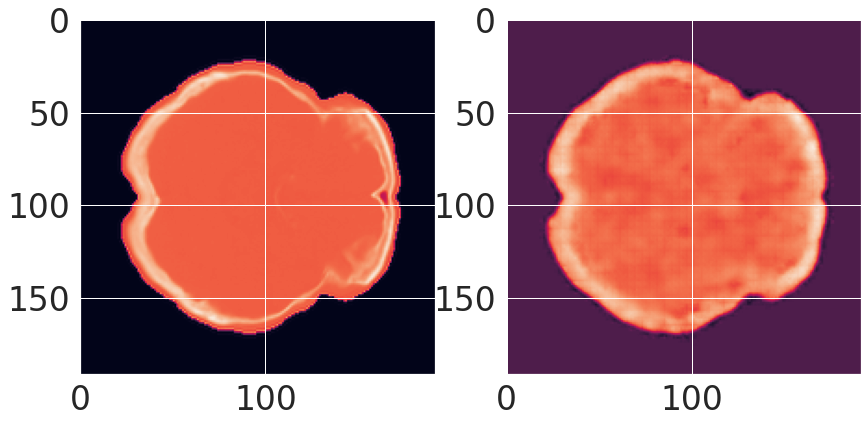

In [68]:
final_pred(model, directories[2], 'CT')
plt.savefig('./figures/'+exp+'/pred_CAE_CT')

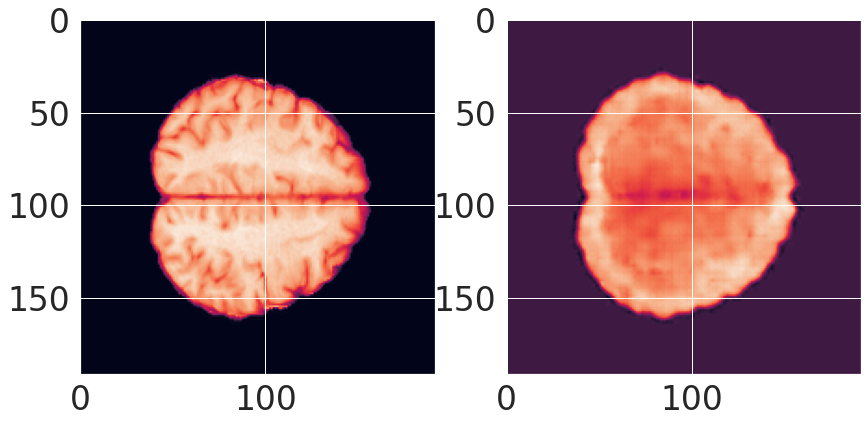

In [69]:
final_pred(model, directories[2], 'MRI')
plt.savefig('./figures/'+exp+'/pred_CAE_MRI')

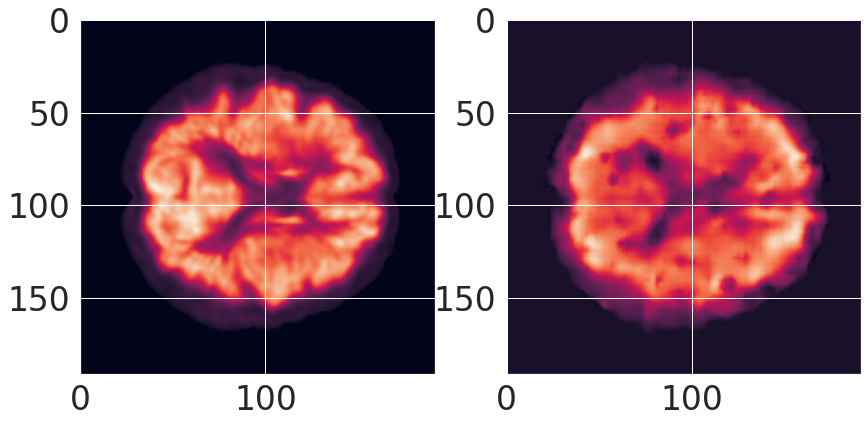

In [70]:
final_pred(model, directories[2], 'PET')
plt.savefig('./figures/'+exp+'/pred_AE_PET')

# Final evaluation on test dataset

In [48]:
test_q, _ = model.predict(x_test, verbose=0)
test_p = target_distribution(test_q)
test_loss = model.fit(x=x_test, y=[test_p, x_test], verbose=0)
print(test_loss.history)

{'loss': [0.007049416580885158], 'clustering_loss': [0.056020312], 'deconv1_loss': [0.0013229176]}


In [49]:
test_q, _ = model.predict(x_test, verbose=0)
test_p = target_distribution(test_q)
test_loss = model.fit(x=x_test, y=[test_p, x_test], verbose=0)
print(test_loss.history)
test_acc = []
y_test_pred = test_q.argmax(1)
test_acc = metrics.acc(y_test, y_test_pred)
print(' Test acc', test_acc)

 Test acc 0.522633744855967


# Plotting clusters (todo)

### Train

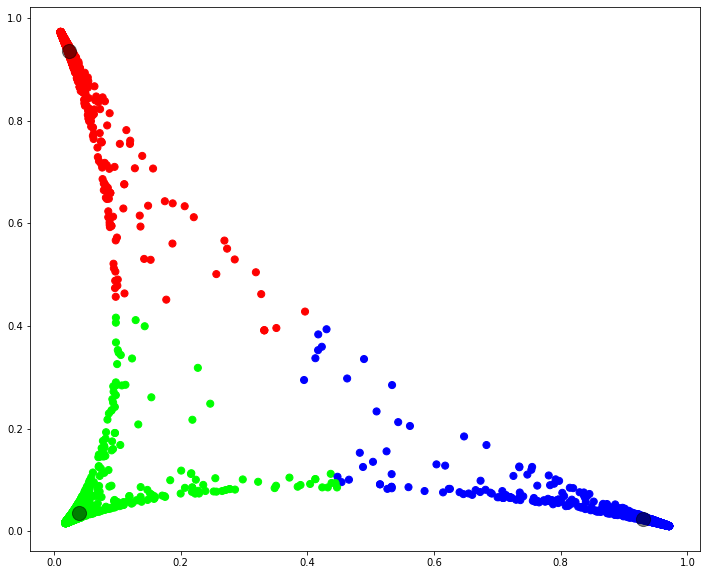

In [50]:
feature_model = model
features = feature_model.predict(x_train)[0]
y_pred = kmeans.fit_predict(features)
plt.figure(figsize=(12, 10))
plt.scatter(features[:, 0], features[:, 1], c=y_pred, s=50, cmap='brg')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Test

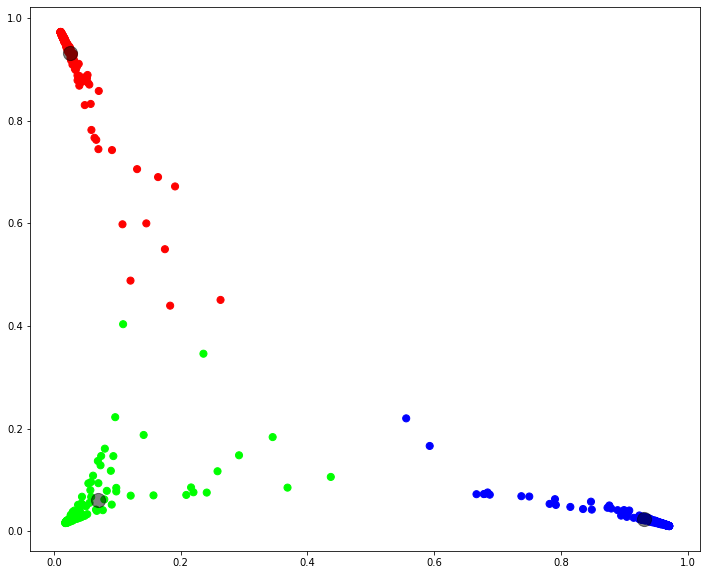

In [51]:
feature_model = model
features = feature_model.predict(x_test)[0]
y_pred = kmeans.fit_predict(features)
plt.figure(figsize=(12, 10))
plt.scatter(features[:, 0], features[:, 1], c=y_pred, s=50, cmap='brg')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Confusion matrix

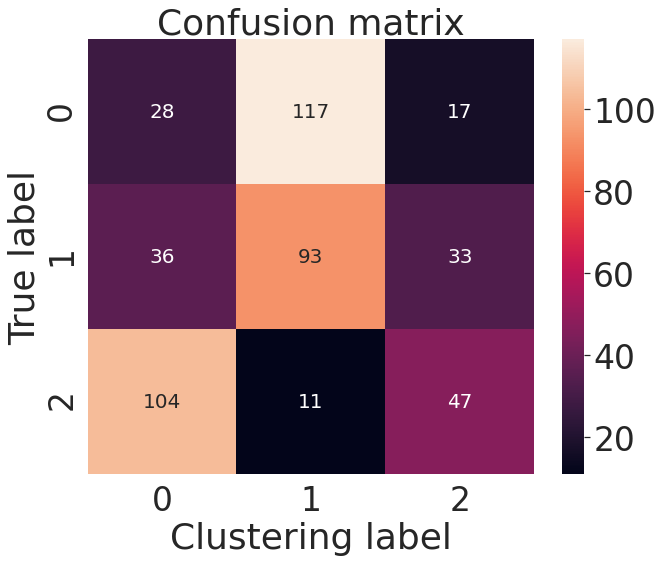

In [52]:
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(
    [int(i) for i in y_test], y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20})
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

In [53]:
y_true = y_test.astype(np.int64)

In [54]:
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

In [55]:
w.argmax(1) 

array([2, 0, 2])

In [56]:
a = ind[0].tolist()
b = ind[1].tolist()

ind = np.array([a, b])
ind

array([[0, 1, 2],
       [2, 0, 1]])

## Comments

The worst class is MRI, why that?